# Machine Learning Model Project -- Default Prediction
## By Roni Kriger

### First, we import all modules required to run this project. They include numpy, pandas, matplotlib, seaborn, and more. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas_profiling
import sweetviz as sv
from sklearn.metrics import accuracy_score
#!pip
warnings.filterwarnings('ignore')
%matplotlib inline

#### Next, we import the Columbia_CLI file into the Jupyter Notebook and drop all columns deemed unnecessary or detrimental to the ML program. We also drop all columns with null values exceeding 50%. 

In [2]:
DF=pd.read_csv(r'C:\Users\dygod\Downloads\Columbia_CLI.csv',index_col=0)
#Drop other columns that we don't need or that have too many null values
DF.drop(['member_id','sub_grade','emp_length','emp_title','pymnt_plan','desc','title','zip_code','addr_state','earliest_cr_line','mths_since_last_delinq','mths_since_last_record','initial_list_status','out_prncp','out_prncp_inv','total_pymnt','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d','application_type','policy_code','collections_12_mths_ex_med','last_credit_pull_d','acc_now_delinq'], axis=1, inplace=True)
#Remove columns that have more than 50% null values
half_count = len(DF) / 2
DF.dropna(thresh=half_count, axis=1, inplace=True)

#### Below, we check the shape of the data set and outline some basic funtions to describe DF

In [3]:
DF.shape

(999, 21)

In [4]:
#DF.shape
#DF.columns
#DF.info()
#DF.describe()
DF.head(3)

,CLI,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,loan_status,purpose,...,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt_inv,total_rec_prncp,total_rec_int
id,,,,,,,,,,,,,,,,,,,,,
1077501,5000,36 months,10.65,162.87,B,RENT,24000.0,Verified,Fully Paid,credit_card,...,0,1,3,0,13648,83.7,9,5831.78,5000.00,861.07
1077430,2500,60 months,15.27,59.83,C,RENT,30000.0,Source Verified,Charged Off,car,...,0,5,3,0,1687,9.4,4,1008.71,456.46,435.17
1077175,2400,36 months,15.96,84.33,C,RENT,12252.0,Not Verified,Fully Paid,small_business,...,0,2,2,0,2956,98.5,10,3003.65,2400.00,603.65


#### The code below detects the presence of null values in the given columns. 

In [5]:
#We must drop the columns that have null values 
print(DF.isnull().max())

CLI                    False
term                   False
int_rate               False
installment            False
grade                  False
home_ownership         False
annual_inc             False
verification_status    False
loan_status            False
purpose                False
dti                    False
delinq_2yrs            False
inq_last_6mths         False
open_acc               False
pub_rec                False
revol_bal              False
revol_util             False
total_acc              False
total_pymnt_inv        False
total_rec_prncp        False
total_rec_int          False
dtype: bool


### The plot diagram below checks for outliers that could possibly decrease the accuracy of our prediction model. The x-axis depicts grade, and the y-axis depicts CLI.

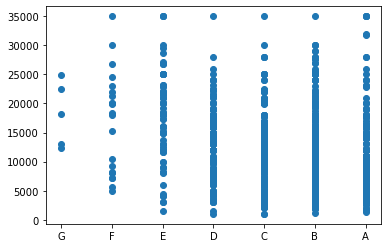

In [6]:
#Checking for outliers that could decrease the accuracy of our prediction model
#Aligning the grades in order
order = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
DF['grade'] = pd.Categorical(DF['grade'], order)
DF.sort_values(by=['grade'], inplace = True)

x=DF['grade']
y=DF['CLI']
plt.scatter(x,y)

In [15]:
#Generating Sweetviz Analysis
#analyzing the dataset
report = sv.analyze(DF)
#display the report
report.show_html('Columbia_CLI.html')


                                             |                                                                …

Report Columbia_CLI.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [18]:
#Generating Pandas_Profiling Report
from pandas_profiling import ProfileReport
prof = ProfileReport(DF)
prof.to_file(output_file='Columbia_CLI.html')

Summarize dataset:   0%|          | 0/35 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Now we check for null values across the data frame. 

In [7]:
#Checking that our data is cleaned and ready to train
print('check the nan value in the DF data')
print(DF.isnull().sum())

check the nan value in the DF data
CLI                    0
term                   0
int_rate               0
installment            0
grade                  0
home_ownership         0
annual_inc             0
verification_status    0
loan_status            0
purpose                0
dti                    0
delinq_2yrs            0
inq_last_6mths         0
open_acc               0
pub_rec                0
revol_bal              0
revol_util             0
total_acc              0
total_pymnt_inv        0
total_rec_prncp        0
total_rec_int          0
dtype: int64


### Below, we exclude values of column 'loan_status' that are either ongoing (current), or late. This interferes with our data as customers in these categories still have their loans pending. We also excluded a single row that included the 'Default' option, as we were unable to identify if the 'default' value had a different meaning than 'Charged Off'. 

In [8]:
DF = DF[DF['loan_status']!='Current']
DF = DF[DF['loan_status']!='Late (31-120 days)']
DF = DF[DF['loan_status']!='Default']

#### Here, we converted the two loan statuses of "Charged Off" and "Fully Paid" into 0s and 1s, respectively, in order to utilize them more efficiently. 

In [9]:
#Turns loan_status column into 0's and 1's
# 1 = Fully Paid or Current, 0 = Charged Off/Defaulted
DF['loan_status'] = DF['loan_status'].replace('Charged Off', 0)
DF['loan_status'] = DF['loan_status'].replace('Fully Paid', 1)

#### Now, we're going to sort out correlations between each column and 'loan_status', since the model should be predicting the loan status in the end. 

In [10]:
# Finding all the correlations and sorting them
correlation = DF.corr()['loan_status'].sort_values()

# Printing the correlations
print(correlation.head(15), '\n')


int_rate          -0.218762
revol_util        -0.113716
dti               -0.080244
inq_last_6mths    -0.063635
CLI               -0.042143
revol_bal         -0.026558
total_rec_int     -0.014337
pub_rec           -0.009987
installment       -0.001145
delinq_2yrs        0.006777
open_acc           0.007346
total_acc          0.013875
annual_inc         0.089169
total_pymnt_inv    0.314362
total_rec_prncp    0.417709
Name: loan_status, dtype: float64 



#### Below, we confirm that loan_status only contains 1s and 0s, as we programmed it to be. 

In [11]:
DF['loan_status'].unique()

array([1, 0], dtype=int64)

In [12]:
DF['loan_status']

id
1060753    1
1061914    0
1060644    1
1058624    0
1058484    0
          ..
1058552    1
1063892    1
1064061    1
1063505    1
1066065    1
Name: loan_status, Length: 905, dtype: int64

In [13]:
DF

,CLI,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,loan_status,purpose,...,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt_inv,total_rec_prncp,total_rec_int
id,,,,,,,,,,,,,,,,,,,,,
1060753,24925,60 months,23.91,715.75,G,RENT,60000.0,Verified,1,credit_card,...,0,2,19,0,14265,98.9,26,37747.49,24925.00,12860.28
1061914,22400,60 months,22.74,628.13,G,RENT,85000.0,Not Verified,0,credit_card,...,2,1,14,0,13773,58.7,16,26376.52,12893.89,13482.63
1060644,18100,60 months,23.91,519.76,G,MORTGAGE,120000.0,Verified,1,debt_consolidation,...,0,3,7,0,31992,99.0,20,22157.63,18100.00,4088.25
1058624,12375,60 months,23.13,349.79,G,RENT,40000.0,Not Verified,0,other,...,0,0,27,0,13768,22.5,31,8530.26,2444.99,4602.60
1058484,7200,36 months,20.89,270.86,F,MORTGAGE,88800.0,Verified,0,debt_consolidation,...,0,3,34,0,17998,57.5,61,6676.85,4068.87,2159.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058552,15000,36 months,7.90,469.36,A,RENT,43000.0,Source Verified,1,debt_consolidation,...,0,0,9,0,12835,60.3,16,16891.50,15000.00,1896.24
1063892,18000,36 months,6.62,552.67,A,MORTGAGE,78000.0,Not Verified,1,debt_consolidation,...,0,0,8,0,16136,25.0,13,19892.95,18000.00,1892.95
1064061,7200,36 months,6.03,219.14,A,MORTGAGE,60000.0,Not Verified,1,other,...,0,0,6,0,3859,6.0,20,7854.56,7200.00,681.92


#### As we learned in class, dummy variables enable us to use a single regression equation to represent multiple groups. In simple terms, it gives us dummies to work with.  

In [14]:
def dummy_variables(DF, columns, prefixes):
    DF = DF.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(DF[column], prefix=prefix)
        DF = pd.concat([DF, dummies], axis=1)
        DF = DF.drop(column, axis=1) 
    return DF

In [15]:
DF = dummy_variables(DF, ['term','grade','home_ownership','verification_status','purpose'],['tm','gr','ho','vs','ps'])

### Now, we begin to prepare the model for its last stages; first by splitting it, then by training and testing it. 

In [1]:
from sklearn.model_selection import train_test_split
model_data = DF
all_features = model_data.drop("loan_status",axis=1)
Targeted_feature = model_data["loan_status"]

# total of 6891 records in dataset
# Divide the data set into two- 70% for train and 30% for test

#X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3)  
X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3,random_state=42)


NameError: name 'DF' is not defined

In [17]:
# Train the logistic regression model with training data

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)


LogisticRegression()

In [18]:
y_pred = logreg.predict(X_test)

### Below, a heatmap represents the results of the model. Logistic regression was applied in order to create a model with an accuracy of 99%. The heatmap shows how accurately the program predicted the test data set. 

--------------The Accuracy of the model----------------------------
Accuracy of logistic regression classifier on test set: 0.993


Text(0.5, 1.05, 'Confusion_matrix')

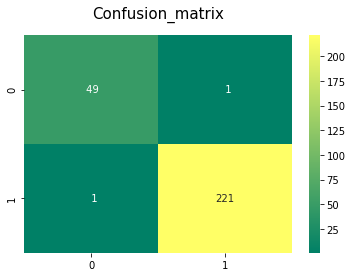

In [19]:
from sklearn.metrics import confusion_matrix
print('--------------The Accuracy of the model----------------------------')
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)


### This is the same code as above, but the train_test_split function now has an increased random state of 67 instead of the previous 42

--------------The Accuracy of the model----------------------------
Accuracy of logistic regression classifier on test set: 1.00


Text(0.5, 1.05, 'Confusion_matrix')

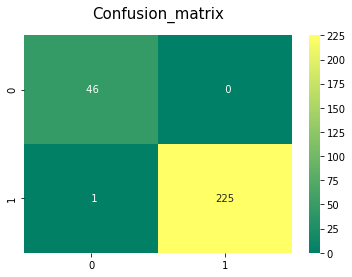

In [20]:
X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3,random_state=67)
# Train the logistic regression model with training data

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
#Predict what it is going to be
y_pred = logreg.predict(X_test)

#Get the accuracy of the model
from sklearn.metrics import confusion_matrix
print('--------------The Accuracy of the model----------------------------')
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)


### The code below identifies the accuracy rate of the model when run 1000 times. This is accomplished by using a for loop at first as each iteration's accuracy rate is added to the accuracy_sum. Then, the accuracy_sum is divided by 1000 to derive the average accuracy of the model.

In [21]:
accuracy_sum = 0
for i in range(0, 1000):
  X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3)
  # Train the logistic regression model with training data

  from sklearn.linear_model import LogisticRegression

  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  #Predict what it is going to be
  y_pred = logreg.predict(X_test)

  #Get the accuracy of the model
  from sklearn.metrics import confusion_matrix
  #print('--------------The Accuracy of the model----------------------------')
  #print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  accuracy_sum += logreg.score(X_test, y_test)
  #sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap="summer")
  #plt.title('Confusion_matrix', y=1.05, size=15)
print(accuracy_sum/1000)

0.9925955882352849


### Below, the Random Forest Classifier is used to create a different method of prediction of the selected data.

--------------The Accuracy of the model----------------------------
Accuracy of logistic regression classifier on test set: 0.95


Text(0.5, 1.05, 'Confusion_matrix')

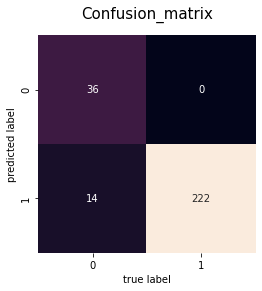

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=2,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)
rf_model.fit(X_train,y_train)
y_pred_rm=rf_model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(rf_model.score(X_test, y_test)))

mat=confusion_matrix(y_test,y_pred_rm)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion_matrix', y=1.05, size=15)

### Comparing the 2 Models

In [23]:
from sklearn.metrics import classification_report
models = [logreg, rf_model]
print('Comparing the Models')
for model in models:
    model.fit(X_train, y_train) # fit the model
    y_pred= model.predict(X_test) # then predict on the test set
    accuracy= accuracy_score(y_test, y_pred) # this gives us how often the algorithm predicted correctly
    clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The accuracy of model {type(model).__name__} is {accuracy:.2f}")
    print(clf_report)
    print("\n")

Comparing the Models
The accuracy of model LogisticRegression is 1.00
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       1.00      1.00      1.00       222

    accuracy                           1.00       272
   macro avg       1.00      0.99      0.99       272
weighted avg       1.00      1.00      1.00       272



The accuracy of model RandomForestClassifier is 0.95
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        50
           1       0.94      1.00      0.97       222

    accuracy                           0.95       272
   macro avg       0.97      0.86      0.90       272
weighted avg       0.95      0.95      0.95       272





{'LogisticRegression'}: 0.990501 (0.010514)
{'RandomForestClassifier'}: 0.924182 (0.030516)


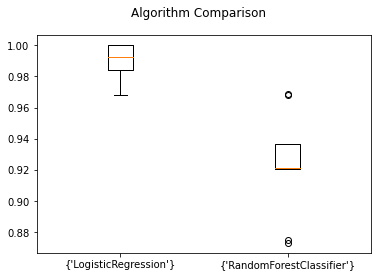

In [24]:
from sklearn import model_selection
results = []
names = []
scoring = 'accuracy'
seed = 42
for model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append({type(model).__name__})
    msg = "%s: %f (%f)" % ({type(model).__name__}, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# XGBoost

#### Import the necessary packages

In [25]:
import sys
!{sys.executable} -m pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

#### Split into train, test and validation set

In [26]:
X_train, X_test, y_train, y_test = train_test_split(model_data, np.asarray(Targeted_feature), train_size=0.7, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

#### The validation set is used to make sure the algorithm is not overfitted, then set the parameters and train it

In [27]:

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {'learning_rate': 0.001, 'max_depth': 6, 'lambda': 0.01}
model = xgb.train(params, dtrain, num_boost_round=10000, evals=[(dval, 'eval')], early_stopping_rounds=10);


[0]	eval-rmse:0.49950
[1]	eval-rmse:0.49900
[2]	eval-rmse:0.49850
[3]	eval-rmse:0.49800
[4]	eval-rmse:0.49750
[5]	eval-rmse:0.49701
[6]	eval-rmse:0.49651
[7]	eval-rmse:0.49601
[8]	eval-rmse:0.49552
[9]	eval-rmse:0.49502
[10]	eval-rmse:0.49453
[11]	eval-rmse:0.49403
[12]	eval-rmse:0.49354
[13]	eval-rmse:0.49305
[14]	eval-rmse:0.49255
[15]	eval-rmse:0.49206
[16]	eval-rmse:0.49157
[17]	eval-rmse:0.49108
[18]	eval-rmse:0.49058
[19]	eval-rmse:0.49010
[20]	eval-rmse:0.48961
[21]	eval-rmse:0.48912
[22]	eval-rmse:0.48863
[23]	eval-rmse:0.48814
[24]	eval-rmse:0.48765
[25]	eval-rmse:0.48716
[26]	eval-rmse:0.48668
[27]	eval-rmse:0.48619
[28]	eval-rmse:0.48570
[29]	eval-rmse:0.48522
[30]	eval-rmse:0.48473
[31]	eval-rmse:0.48425
[32]	eval-rmse:0.48376
[33]	eval-rmse:0.48328
[34]	eval-rmse:0.48279
[35]	eval-rmse:0.48231
[36]	eval-rmse:0.48183
[37]	eval-rmse:0.48135
[38]	eval-rmse:0.48087
[39]	eval-rmse:0.48039
[40]	eval-rmse:0.47991
[41]	eval-rmse:0.47943
[42]	eval-rmse:0.47895
[43]	eval-rmse:0.4784

#### Predict the results of the test set, and print the output

In [28]:
#y_true = np.array(y_test)
y_pred = model.predict(dtest)
print('Mean squared error: %.2f'
      % (mean_squared_error((y_test), (y_pred))))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Mean squared error: 0.00
Coefficient of determination: 1.00


#### Effects of XG Boost

In [35]:
models = [logreg, rf_model]
print('Comparing the Models')
for model in models:
    model.fit(X_train, y_train) # fit the model
    y_pred= model.predict(X_test) # then predict on the test set
    accuracy= accuracy_score(y_test, y_pred) # this gives us how often the algorithm predicted correctly
    clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The accuracy of model {type(model).__name__} is {accuracy:.2f}")
    print(clf_report)
    print("\n")

Comparing the Models
The accuracy of model LogisticRegression is 0.99
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       1.00      0.99      1.00       217

    accuracy                           0.99       272
   macro avg       0.98      1.00      0.99       272
weighted avg       0.99      0.99      0.99       272



The accuracy of model RandomForestClassifier is 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00       217

    accuracy                           1.00       272
   macro avg       1.00      1.00      1.00       272
weighted avg       1.00      1.00      1.00       272



